In [1]:
source('../R/libs.R')
source('../R/utils.R')
source('../R/utils_plotting.R')


# Installation instructions




## Symphony

For mapping query to Atlas. 


In [3]:
tryCatch(
    library(symphony),
    error = function(e) {
        devtools::install_github('immunogenomics/symphony')
        library(symphony)
    }
)

## Presto 

For downstream cluster marker analysis. 

In [4]:
devtools::install_github('immunogenomics/presto', ref='glmm')
library(presto)


Skipping install of 'presto' from a github remote, the SHA1 (e7beffc4) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: Rcpp



# Symphony Mapping

## Load data

In [5]:
## Load count matrix and meta data table for skin fibroblasts
exprs_raw <- readRDS('../data/dermal_counts.rds')
meta_data <- readRDS('../data/dermal_meta.rds')


In [6]:
## Load the Fibroblast Atlas 
atlas <- readRDS('../data/fibroblast_atlas.rds')

## Map to atlas 

In [7]:
query_dermal <- mapQuery(
    exp_query = exprs_raw, ## Dermal gene-by-cell UMI matrix
    metadata_query = meta_data, ## Dermal meta data table 
    ref_obj = atlas, ## Reference to map to 
    vars = 'LibraryID', ## Harmonize over LibraryID in the dermal dataset
    verbose = TRUE, ## For this tutorial, let's print progress of intermediate steps
    do_normalize = TRUE, ## Normalize data, since input is raw count matrix
    do_umap = FALSE ## Ignore this for now 
)
## TODO: save query counts in Symphony
query_dermal$exprs_raw <- exprs_raw

Normalizing

Scaling and synchronizing query gene expression

Found 9476 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

All done!



## UMAP 


In [8]:
query_dermal$umap <- as.matrix(make_predictions(atlas, 'umap', query_dermal))

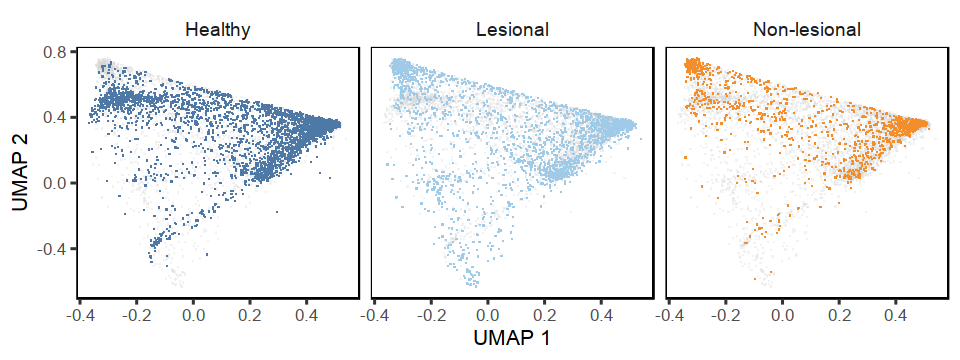

In [9]:
fig.size(3, 8)
do_scatter(query_dermal$umap, query_dermal$meta_data, 'tissue_type', quo(tissue_type), do_labels=FALSE)

## Predict clusters

In [10]:
prob_assign <- make_predictions(atlas, 'Cluster', query_dermal)


These prediction models make probabilistic assignments to Cluster. We can visualize these in a heatmap: 

- `Rows:` reference clusters
- `Columns:` query cells
- `Color:` assignment probability

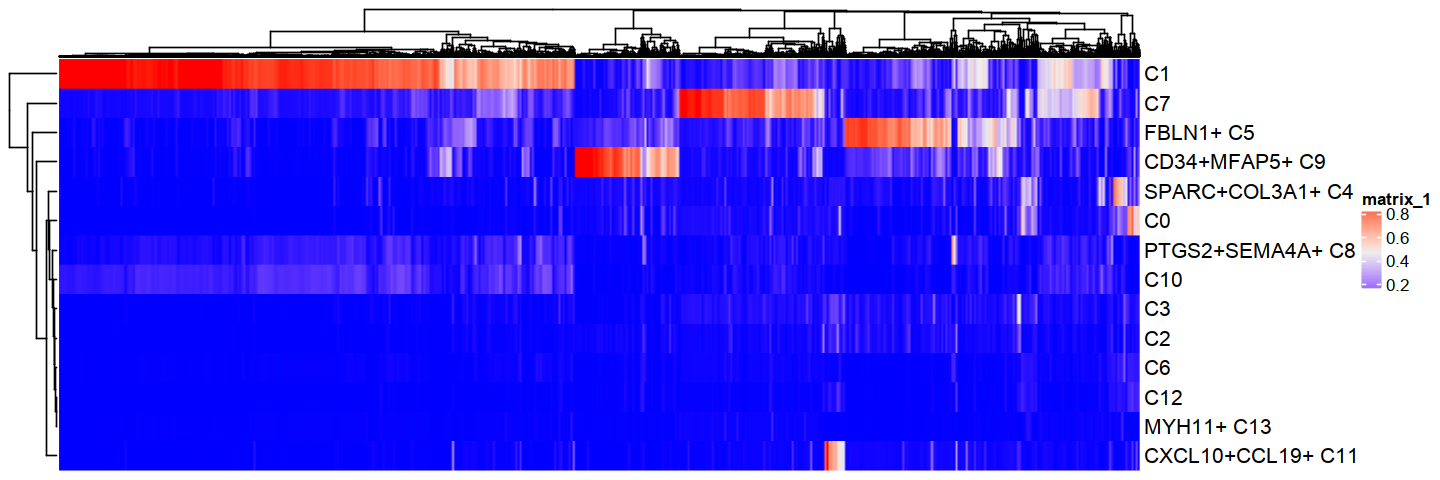

In [11]:
fig.size(4, 12)
Heatmap(t(as(prob_assign, 'matrix')), show_column_names=FALSE)

# Downstream analyses

## Abundance

To look at cluster abundances among donors, we'll make hard assignments. 

In [12]:
query_dermal$meta_data$Cluster <- colnames(prob_assign)[apply(prob_assign, 1, which.max)]

With these abundances, we can look at how they are distributed in the different clinical groups. 

`geom_smooth()` using formula 'y ~ x'



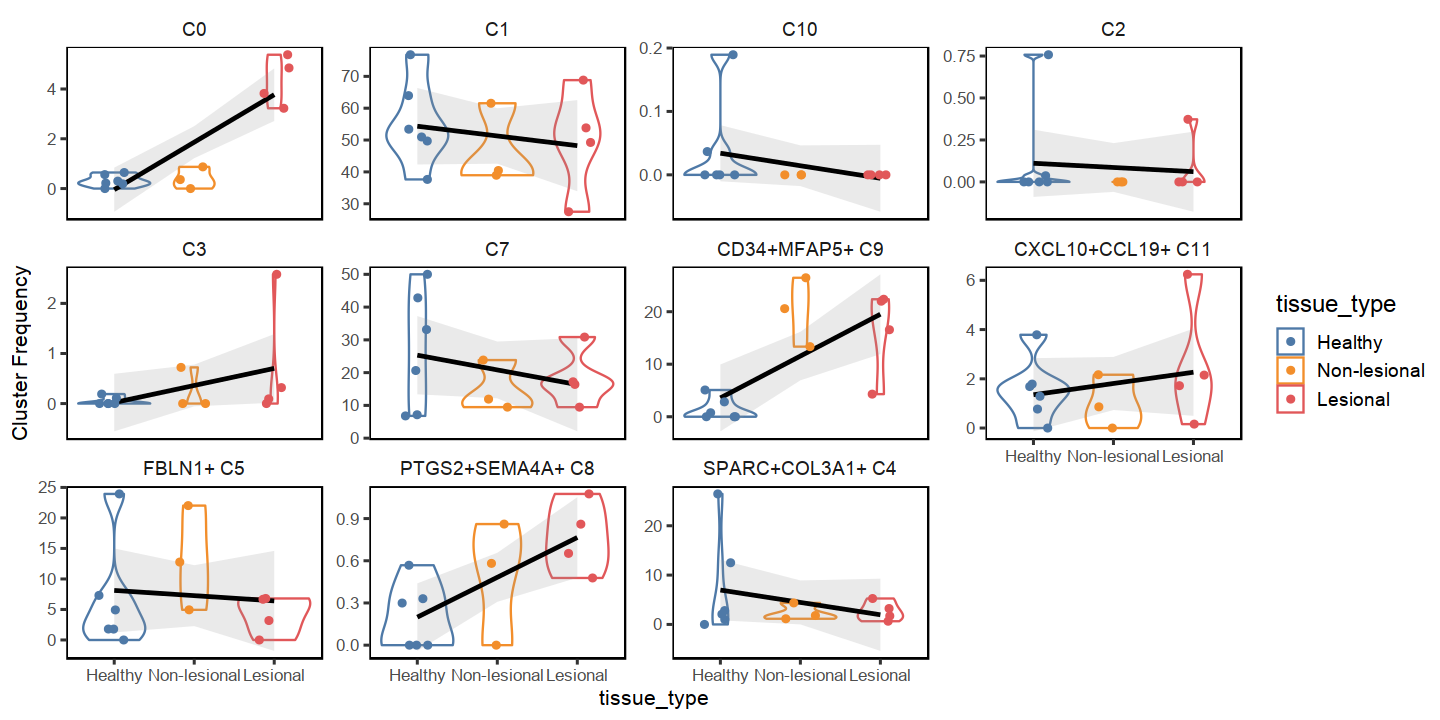

In [13]:
fig.size(6, 12)
query_dermal$meta_data %>% 
    with(prop.table(table(Cluster, LibraryID), 2)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(query_dermal$meta_data, LibraryID, tissue_type)), by='LibraryID') %>% 
    dplyr::mutate(tissue_type = factor(tissue_type, c('Healthy', 'Non-lesional', 'Lesional'))) %>% 
    ggplot(aes(tissue_type, 100 * N, color = tissue_type)) + 
        geom_violin(fill = NA) + 
        geom_smooth(method = 'lm', data = . %>% dplyr::mutate(tissue_type = as.integer(tissue_type)), color='black', alpha=.2) + 
        geom_jitter(width = .2, height = 0) + 
        facet_wrap(~Cluster, scales='free_y') +
        labs(y = 'Cluster Frequency') + 
        scale_color_tableau()


In the paper, we associated the degree of inflammation in each sample, measured as the frequency of immune cells in each sample, with the frequency of each cluster. 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



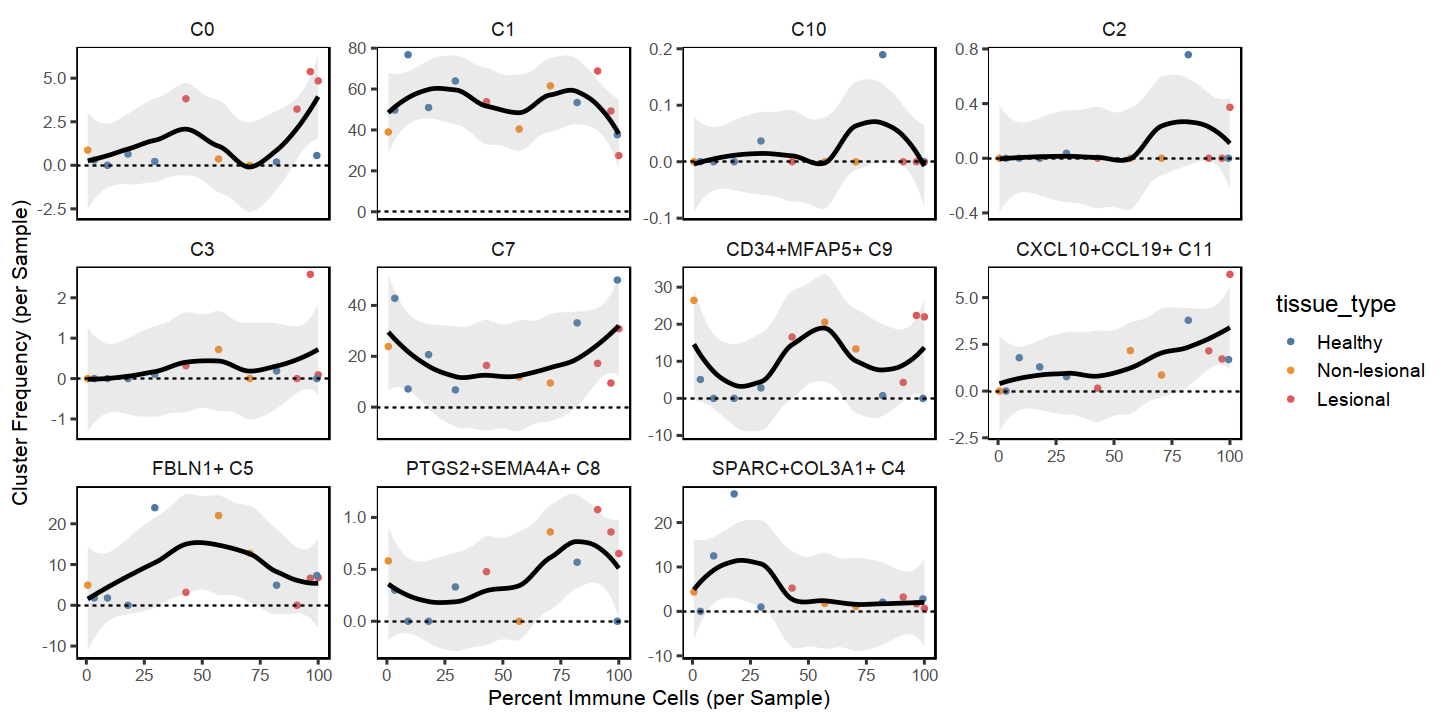

In [14]:
fig.size(6, 12)
query_dermal$meta_data %>% 
    with(prop.table(table(Cluster, LibraryID), 2)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(query_dermal$meta_data, LibraryID, tissue_type, InflamScore_beta)), by='LibraryID') %>% 
    dplyr::mutate(tissue_type = factor(tissue_type, c('Healthy', 'Non-lesional', 'Lesional'))) %>% 
    ggplot(aes(100 * InflamScore_beta, 100 * N, color = tissue_type)) + 
        geom_point(shape = 16) + 
        geom_smooth(color = 'black', alpha = .2) + 
        geom_hline(yintercept = 0, linetype = 2) + 
#         geom_smooth(method = 'lm', color = 'black', alpha = .2) + 
        facet_wrap(~Cluster, scales='free_y') + 
        labs(x = 'Percent Immune Cells (per Sample)', y = 'Cluster Frequency (per Sample)') + 
        scale_color_tableau()


## Cluster markers

In this section, we'll compare clusters markers 

Let's confirm that the gene expession of the mapped data 


### Presto

In [15]:
## Collapse Counts
pb <- presto::collapse_counts(
    query_dermal$exprs_raw,
    query_dermal$meta_data,
    c('LibraryID', 'Cluster'),
    keep_n=TRUE, 
    how='sum',
    min_cells_per_group = 3
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))


CAREFUL: get_norm makes very strong assumptions about data



In [16]:
## For efficiency, let's just test top markers per cluster 
genes_test <- data.table(atlas$markers)[, head(.SD[order(-Zscore)], 50), by = .(Cluster)] %>% with(unique(Symbol))
length(genes_test)

## Alternatively, we could look at all well expressed genes in the query 
# genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 3) >= 3)]# %>% head(100)
# length(genes_test)


[1] 508

In [17]:
## First, we fit lme4 models
suppressWarnings({
    query_dermal$presto <- presto.presto(
        formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
        design = pb$meta_data, 
        response = pb$counts_mat, 
        size_varname = 'logUMI',
        features = genes_test,
        ncore = 20,
        nsim = 1e3,
        effects_cov = c('Cluster'),
        min_sigma = .5,
        verbose = TRUE
    ) 
})


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



In [18]:
## Get effects
contrasts_mat <- make_contrast.presto(query_dermal$presto, 'Cluster')
query_dermal$markers <- contrasts.presto(query_dermal$presto, contrasts_mat, one_tailed = FALSE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    dplyr::select(-contrast) %>% 
    arrange(pvalue) %>% 
    dplyr::select(Cluster, Symbol=feature, logFC=beta, Zscore=zscore, Pvalue=pvalue) 



In [19]:
head(query_dermal$markers)

Cluster,Symbol,logFC,Zscore,Pvalue
<chr>,<chr>,<dbl>,<dbl>,<dbl>
SPARC+COL3A1+ C4,ADH1B,-2.637429,-11.268922,1.868431e-29
SPARC+COL3A1+ C4,C3,-2.738375,-10.903082,1.114183e-27
SPARC+COL3A1+ C4,CXCL12,-1.906992,-9.069184,1.199112e-19
CD34+MFAP5+ C9,PCOLCE2,2.520644,8.984824,2.591489e-19
SPARC+COL3A1+ C4,PLA2G2A,-3.032637,-8.370560,5.734529e-17
CD34+MFAP5+ C9,C1QTNF3,3.172244,8.267416,1.368936e-16


### Compare to reference

Joining, by = "Cluster"

`geom_smooth()` using formula 'y ~ x'



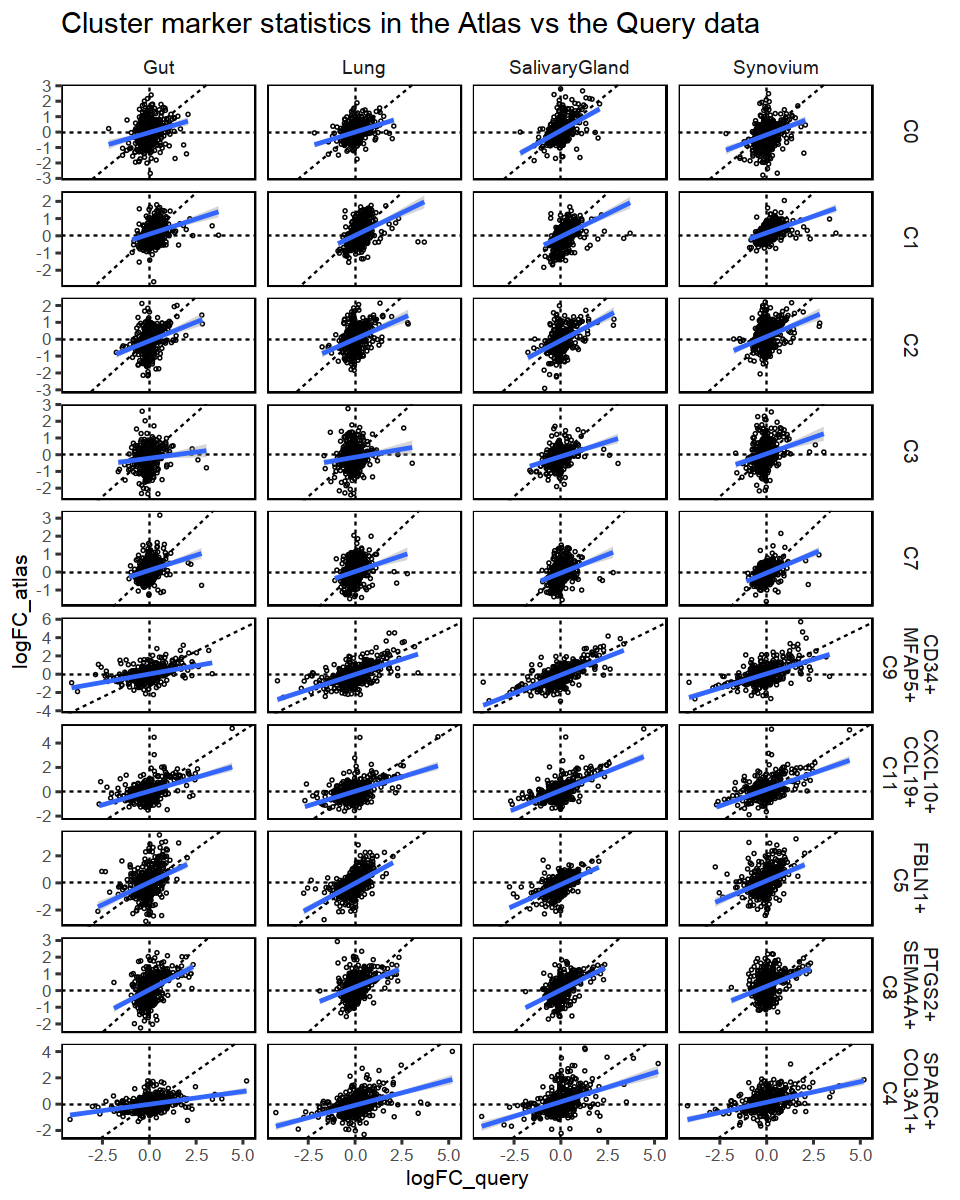

In [20]:
fig.size(10, 8)
inner_join(query_dermal$markers, atlas$markers, by = c('Symbol', 'Cluster'), suffix = c('_query', '_atlas')) %>% 
    left_join(
        ## For nicer plotting of longer cluster names
        tibble(
            Cluster = unique(atlas$markers$Cluster),
            Cluster_nice = strsplit(Cluster, '\\+') %>% map_chr(function(s) paste(s, collapse = '+\n'))
        )
    ) %>% 
    ggplot(aes(logFC_query, logFC_atlas)) + 
        geom_point(size = .5, shape = 21) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_abline(linetype = 2) + 
        geom_smooth(method = 'lm', alpha = .4) + 
        facet_grid(Cluster_nice~Tissue, scales = 'free') + 
        labs(title = 'Cluster marker statistics in the Atlas vs the Query data') + 
        NULL

The scatterplots above show us that the query logFC numbers are slightly different per atlas-tissue. This suggests that dermal fibroblasts resemble some tissues better than others. Let's see which ones exactly by computing the correlation stats in the plots above. 

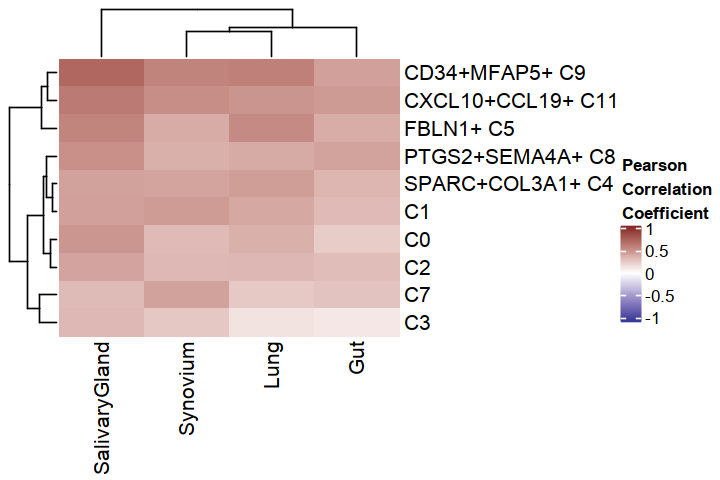

In [21]:
fig.size(4, 6)
inner_join(query_dermal$markers, atlas$markers, by = c('Symbol', 'Cluster'), suffix = c('_query', '_atlas')) %>% 
    split(.$Tissue) %>% 
    map(function(.SD) {
        data.table(.SD)[, .(rho = cor.test(~logFC_query + logFC_atlas)$estimate), by = .(Cluster)]
    }) %>% 
    bind_rows(.id = 'Tissue') %>% 
    tidyr::spread(Tissue, rho) %>% 
    tibble::column_to_rownames('Cluster') %>% 
    as('matrix') %>% 
    Heatmap(
        name = 'Pearson\nCorrelation\nCoefficient',
        colorRamp2(c(-1, 0, 1), c(muted('blue'), 'white', muted('red'))),    

    )
    

### Skin-specific genes

Which genes mark clusters are present in the Skin that were not found in any of the atlas reference tissues? 

The code below finds that in cluster C11, PLEKHH2 is not upregulated in the other tissues but is in the skin. 


In [22]:
inner_join(query_dermal$markers, atlas$markers, by = c('Symbol', 'Cluster'), suffix = c('_query', '_atlas')) %>% 
    ## Focus on Cluster C11
    subset(grepl('C11$', Cluster)) %>% 
    ## Up in query but not in ref
    subset(logFC_query > 1 & Pvalue_atlas > .1) %>% 
    ## For all 4 atlas tissues 
    split(.$Symbol) %>% map(function(.SD) dplyr::mutate(.SD, N=nrow(.SD))) %>% 
    bind_rows() %>% subset(N == 4) %>% dplyr::select(-N)


Cluster,Symbol,logFC_query,Zscore_query,Pvalue_query,Tissue,logFC_atlas,Zscore_atlas,Pvalue_atlas
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CXCL10+CCL19+ C11,PLEKHH2,1.017424,4.629463,3.666155e-06,Lung,0.2071771,0.6508339,0.2575769
CXCL10+CCL19+ C11,PLEKHH2,1.017424,4.629463,3.666155e-06,Synovium,0.1616821,0.5058464,0.3064822
CXCL10+CCL19+ C11,PLEKHH2,1.017424,4.629463,3.666155e-06,Gut,-0.1617938,-0.5114105,0.6954682
CXCL10+CCL19+ C11,PLEKHH2,1.017424,4.629463,3.666155e-06,SalivaryGland,-0.3603668,-1.0267086,0.8477212


# SessionInfo

In [23]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/ik936/anaconda3/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] presto_1.0.0         Rcpp_1.0.6           symphony_1.0        
 [4] patchwork_1.0.0.9000 ComplexHeatmap_2.2.0 circlize_0.4.8      
 [7] uwot_0.1.10.9000     scales_1.1.1         lme4_1.1-23         
[10] furrr_0.2.0          future_1.21.0        purrr_0.3.4   